# Классификация

## Импорт библиотек

 Для кластеризации нам понадобятся следующие библиотеки:
* pandas - для работы с таблицей данных
* numpy - для работы с массивами
* nltk, pymorphy - для предобработки запросов
* sklearn - модели векторизаторов и кластеризаторов
* pickle - сериализация и десериализация данных, необходим для сохранения весов модели

In [1]:
# Спрятать warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymorphy2 import MorphAnalyzer
import numpy as np
import pandas as pd
import nltk
import pickle
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Для нормализации текста
from normalize import normalize_text
# загрузка модулей nltk
nltk.download('punkt')
nltk.download('stopwords')
# морфологический анализатор для русского языка
morph = MorphAnalyzer()

[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Подготовка данных

### Загрузка и чистка данных

In [3]:
df = pd.read_csv("../data/data_marketed.csv")
print(df.head())

# Исходный текст
df = df[['text', 'label']]
# Нормализованный текст
#df = df[['normal_text', 'label']]
df.columns = ['text', 'label']
df = df.dropna()
print(df.head())
df

   Unnamed: 0                                    text  \
0           0   имеются ли у вас номера бизнес класса   
1           1         Добрый день Какое время заезда    
2           2            скажите номера какие имеются   
3           3               когда можно будет заехать   
4           4  какие услуги гостинице есть дополнение   

                         normal_text   label  
0         иметься номер бизнес класс  номера  
1      добрый день какой время заезд   время  
2        сказать номер какой иметься  номера  
3                            заехать   время  
4  какой услуга гостиница дополнение  услуги  
                                     text   label
0   имеются ли у вас номера бизнес класса  номера
1         Добрый день Какое время заезда    время
2            скажите номера какие имеются  номера
3               когда можно будет заехать   время
4  какие услуги гостинице есть дополнение  услуги


,text,label
0,имеются ли у вас номера бизнес класса,номера
1,Добрый день Какое время заезда,время
2,скажите номера какие имеются,номера
3,когда можно будет заехать,время
4,какие услуги гостинице есть дополнение,услуги
...,...,...
488,Здравствуйте Мне нужно оформить бронь номера,время
489,Здравствуйте где я смогу оставить машину,время
490,хочу узнать какие есть услуги в гостинице,услуги
491,во сколько можно въезжать в номер,время


In [4]:
# балансируем выборку
df = df.groupby('label').head(df.groupby('label').size().min())
df

,text,label
0,имеются ли у вас номера бизнес класса,номера
1,Добрый день Какое время заезда,время
2,скажите номера какие имеются,номера
3,когда можно будет заехать,время
4,какие услуги гостинице есть дополнение,услуги
...,...,...
464,какие есть услуги в гостинице,услуги
465,добрый день в вашей гостинице есть дополнитель...,услуги
487,Здравствуйте какие услуги предлагает отель,услуги
490,хочу узнать какие есть услуги в гостинице,услуги


Смотрим на сбалансированность выборки

In [5]:
# число классов
df.label.value_counts()

номера           51
время            51
услуги           51
забронировать    51
парковка         51
Name: label, dtype: int64

### Нормализация текста

**Нормализация текста** - процесс приведения текста к нормальному виду, то есть каждый токен в предложении будет заменен на его нормальную форму.
Производится в файле `normalize.py`

In [6]:
# нормализация каждой строки из таблицы
df["normal_text"] = [normalize_text(text, stop_words=True) for text in df.text]

print(df.normal_text)

print(df.head())

0                           иметься номер бизнес класс
1                        добрый день какой время заезд
2                          сказать номер какой иметься
3                                              заехать
4                    какой услуга гостиница дополнение
                            ...                       
464                             какой услуга гостиница
465    добрый день ваш гостиница дополнительный услуга
487         здравствуйте какой услуга предлагать отель
490               хотеть узнать какой услуга гостиница
492        добрый день гостиница дополнительный услуга
Name: normal_text, Length: 255, dtype: object
                                     text   label  \
0   имеются ли у вас номера бизнес класса  номера   
1         Добрый день Какое время заезда    время   
2            скажите номера какие имеются  номера   
3               когда можно будет заехать   время   
4  какие услуги гостинице есть дополнение  услуги   

                         norma

## Векторное представление

**Представление запросов в виде векторов**

В больших наборах текстовых данных некоторые слова будут встречаться в большом количестве текстов и следовательно нести мало значимой информации о них. Чтобы снизить значимость частотных слов и увеличить ее для редких слов, применяют $tf\times idf$ векторизатор.

**TF (term frequency)** - частота слова - доля конкретного слова ($q$) среди всех слов ($t$) документа ($D$)
$$
TF = \frac{f(q,D)}{f(t,D)}
$$
где $f(q, D)$ - частота конкретного слова в рамках текущего документа, $f(t, D)$ - частота всех слов в рамках текущего документа.

**IDF (inverted document frequency)**  - обратная частота документа, показывает насколько часто встречается слово во всех документах $N$.
$$
IDF = log\frac{N}{N(q)}
$$
где $N$ - число всех документов, $N(q)$ - число документов, где встречается $q$.

На практике используется обычно используется формула со сглаживанием
$$
IDF = log\frac{N+1}{N(q)+1}
$$

In [7]:
# TfidfVectorizer() работает следующим образом:
# 1. преобразует запросы с помощью CountVectorizer() - который суммирует one-hot эмбеддинги всех слов запроса
# 2. трансформирует полученные эмбеддинги, применяя tf*idf

# Векторизуем запросы
vectorizer = TfidfVectorizer()
#text_embeddings = vectorizer.fit_transform(df.text)
x = vectorizer.fit_transform(df.normal_text)
print(x)

  (0, 80)	0.6026993571436146
  (0, 10)	0.6475668200326267
  (0, 98)	0.19267075905516196
  (0, 71)	0.4246041416385542
  (1, 54)	0.6408292024633906
  (1, 22)	0.4898121155703305
  (1, 78)	0.29818855199704536
  (1, 39)	0.37413310444629727
  (1, 41)	0.34717435436093685
  (2, 154)	0.6244933073550214
  (2, 78)	0.3737855363057096
  (2, 98)	0.28337358907672816
  (2, 71)	0.6244933073550214
  (3, 55)	1.0
  (4, 45)	0.8012629374010565
  (4, 31)	0.37194948679414375
  (4, 177)	0.3474829168892119
  (4, 78)	0.3144628863493571
  (5, 111)	0.22225470643842282
  (5, 12)	0.597795458199901
  (5, 42)	0.597795458199901
  (5, 66)	0.23608006950293414
  (5, 22)	0.38537674996584514
  (5, 98)	0.17786227015970368
  (6, 82)	0.566225136648855
  :	:
  (249, 177)	0.35817583438636513
  (250, 31)	0.621664365744637
  (250, 177)	0.5807717305833623
  (250, 78)	0.5255831174215211
  (251, 47)	0.47290037995191075
  (251, 14)	0.39535742659840906
  (251, 31)	0.39535742659840906
  (251, 177)	0.3693510992374642
  (251, 39)	0.419382

In [8]:
# метки классов
y = list(df.label)
len(y)

255

## Классификация

Разделение датасета на train и test

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)

# Хранение оценки точности для каждого метода
rscore = {
    "Метод": [],
    "Точность": [],
}
# Путь к моделям
path = "../data/"

## Метод опорных векторов (Support Vectors Classifier)

Главная цель этого метода классификации - найти такую гиперплоскость, разделяющую пространство на n частей, чтобы расстояние от плоскости до ближайших элементов каждого класса было максимальным. Эти ближайшие элементы и называются опорными векторами.

In [10]:
from sklearn.svm import SVC

In [11]:
clf_svc = SVC(probability=True)
clf_svc.fit(x_train, y_train)

SVC(probability=True)

In [12]:
result_vector = vectorizer.transform(['забронировать номер в отеле на завтра'])
clf_svc.predict(result_vector)

array(['забронировать'], dtype='<U13')

In [13]:
score = clf_svc.score(x_test, y_test)

rscore["Метод"].append("Опорные векторы (Support Vectors Classifier")
rscore["Точность"].append(score)

print(score)

0.9411764705882353


In [14]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, clf_svc.predict(x_test)
print(classification_report(y_true, y_pred, zero_division=1))

               precision    recall  f1-score   support

        время       0.90      0.82      0.86        11
забронировать       1.00      1.00      1.00        12
       номера       0.89      1.00      0.94         8
     парковка       1.00      0.92      0.96        13
       услуги       0.88      1.00      0.93         7

     accuracy                           0.94        51
    macro avg       0.93      0.95      0.94        51
 weighted avg       0.94      0.94      0.94        51



In [15]:
# Сохранение модели
pickle.dump(clf_svc, open(path + "model_svc.sav",'wb'))
# Сохранение векторизатора
pickle.dump(vectorizer, open(path + "vec_svc.pk",'wb'))

## Ближайшие соседи (KNeighborsClassifier)

Класс вектора определяется на основании ближайших $k$ соседей, к какому классу принадлежат большинство из них - к такому классу относится и текущий вектор.

Можно изменять способ подсчета расстояния между векторами, по умолчанию используется евклидово расстояние.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)

Выбор оптимального числа соседей

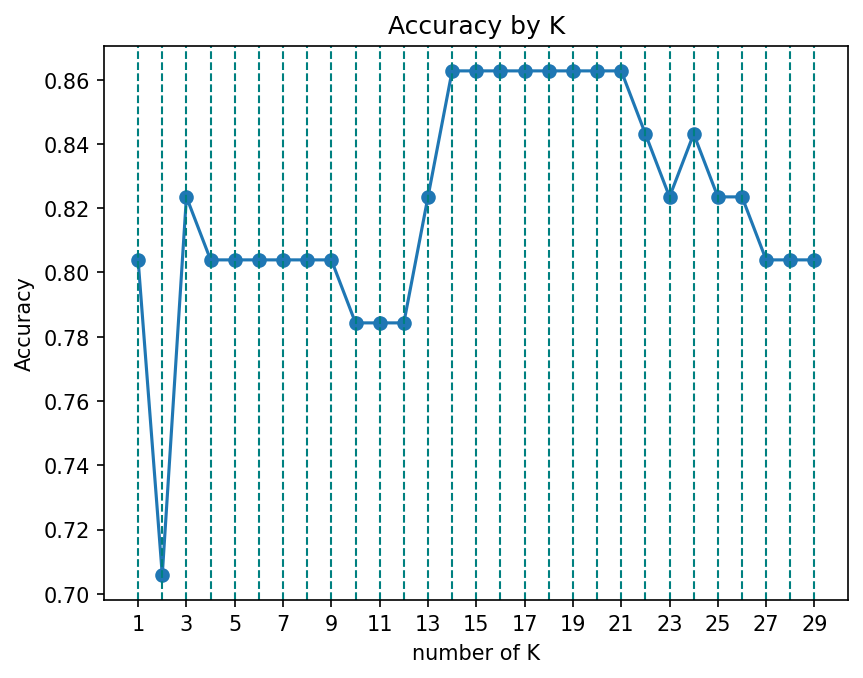

In [18]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def find_optimal_k(x_train, y_train, max_k):
    iters = range(1, max_k, 1)
    acc = []
    for k in iters:
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(x_train, y_train)
      acc.append(knn.score(x_test, y_test))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, acc, marker='o')
    ax.set_xlabel('number of K')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_xticks(ax.get_xticks()[::2])
    for k in iters:
        ax.axvline(x=k, color='teal', ls='--', lw=1) 
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by K')
    f.set_dpi(150)
    

max_k = 30
find_optimal_k(x_train, y_train, max_k)

В данном случае устойчивый результат показывает $14 \le k \le 21$

In [19]:
#n_neighbors = 4
n_neighbors = 15
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(x_train, y_train)
score = knn.score(x_test, y_test)
rscore["Метод"].append("Ближайшие соседи (KNeighborsClassifier)")
rscore["Точность"].append(score)
print(score)

0.8627450980392157


In [20]:
y_true, y_pred = y_test, knn.predict(x_test)
print(classification_report(y_true, y_pred, zero_division=1))

               precision    recall  f1-score   support

        время       1.00      0.45      0.62        11
забронировать       0.80      1.00      0.89        12
       номера       0.80      1.00      0.89         8
     парковка       1.00      0.92      0.96        13
       услуги       0.78      1.00      0.88         7

     accuracy                           0.86        51
    macro avg       0.88      0.88      0.85        51
 weighted avg       0.89      0.86      0.85        51



In [21]:
result_vector = vectorizer.transform(['забронировать номер в отеле на завтра'])
print('Запрос: ', knn.predict_proba(result_vector))

Запрос:  [[0. 1. 0. 0. 0.]]


In [22]:
# Сохранение модели
pickle.dump(knn, open(path + "model_knn.sav",'wb'))
# Сохранение векторизатора
pickle.dump(vectorizer, open(path + "vec_knn.pk",'wb'))

## Логистическая регрессия (LogisticRegressionCV)

В данном случае результатом классификации служит получение распределения вероятности попадания запроса в определенный класс

In [23]:
from sklearn.linear_model import LogisticRegressionCV
logreg_clf = LogisticRegressionCV(multi_class = "multinomial")
logreg_clf.fit(x_train, y_train)

LogisticRegressionCV(multi_class='multinomial')

In [24]:
score = logreg_clf.score(x_test, y_test)
rscore["Метод"].append("Логистическая регрессия (LogisticRegressionCV)")
rscore["Точность"].append(score)
print(score)

0.9215686274509803


In [25]:
y_pred = logreg_clf.predict(x_test)
print(classification_report(y_true, y_pred, zero_division=1))

               precision    recall  f1-score   support

        время       1.00      0.64      0.78        11
забронировать       0.92      1.00      0.96        12
       номера       0.89      1.00      0.94         8
     парковка       1.00      1.00      1.00        13
       услуги       0.78      1.00      0.88         7

     accuracy                           0.92        51
    macro avg       0.92      0.93      0.91        51
 weighted avg       0.93      0.92      0.92        51



Пример запроса к модели

In [26]:
result_vector = vectorizer.transform(['забронировать номер в отеле на завтра'])
print('Запрос: ', logreg_clf.predict_proba(result_vector))

Запрос:  [[0.01920184 0.88047254 0.09207097 0.00444861 0.00380604]]


In [27]:
# Сохранение модели
pickle.dump(logreg_clf, open(path + "model_logreg.sav",'wb'))
# Сохранение векторизатора
pickle.dump(vectorizer, open(path + "vec_logreg.pk",'wb'))

## Точность моделей

In [28]:
pd.DataFrame.from_dict(rscore)

,Метод,Точность
0,Опорные векторы (Support Vectors Classifier,0.941176
1,Ближайшие соседи (KNeighborsClassifier),0.862745
2,Логистическая регрессия (LogisticRegressionCV),0.921569


Выбираем подходящую модель. Каждая модель и векторизатор сохранены в отдельный файл. Они будут использоваться ботом.